# Batch Stream Active Learning with Pool-based Query Strategies
In this notebook, we will show how pool-based active learning strategies can be used in stream environments by processing the incoming data in batches.

In [1]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d
from skactiveml.classifier import ParzenWindowClassifier
from skactiveml.pool import RandomSampling, UncertaintySampling, ProbabilisticAL, CostEmbeddingAL, EpistemicUncertaintySampling
from skactiveml.utils import call_func, MISSING_LABEL

## Initialize Batch Stream Parameters
Before the experiments can start, we need to construct a random data set. For this, we specify the necessary parameters in the cell below. We specify the length of the data stream (stream_length) and the size of the sliding window that defines the available training data (training_size). To create the stream environment, we define the size for each batch (stream_batch_size) and the number of acquisitions within a batch (query_batch_size).

In [2]:
# number of instances that are provided to the classifier
init_train_length = 10
# the length of the data stream
stream_length = 10000
# the size of the sliding window that limits the training data
training_size = 1000
# define the size for each batch
stream_batch_size = 10
# define the number of acquisitions within a batch
query_batch_size = 2
# number of classes
n_classes = 2
# list of all available classes
classes = [c for c in range(n_classes)]

## Random Seed Generation
To make the experiments repeatable, we will use the random_state object to generate all other random seeds, such that we only need to explicitly specify a single random seed. The get_randomseed function simplifies the generation of a new random seed using the random_state object.

In [3]:
# random state that is used to generate random seeds
random_state = np.random.RandomState(0)

def get_randomseed(random_state):
    return random_state.randint(2**31-1)

## Generate And Initialize Data Set
The next block initializes the tested data set. We use `scikit-learn` to generate a random dataset with our pre-defined stream length. The data set consists of multiple parts. X represents the location of the instance within the feature space. The class for each instance is denoted by y. 
For models that need at least some initial training data, we generate samples to train an initial model. These are denoted by the suffix "_init", while all data used within the active learning cycle are denoted by the suffix "_stream". For this notebook we evaluate the performance of each query strategy using Prequential Evaluation. If a hold-out test dataset is used, it should be initialized here as well.

In [4]:
X, y_centers = sklearn.datasets.make_blobs(
    n_samples=init_train_length + stream_length,
    centers=30,
    random_state=get_randomseed(random_state),
    shuffle=True)
y = y_centers % 2
X_init = X[:init_train_length, :]
y_init = y[:init_train_length]
X_stream = X[init_train_length:, :]
y_stream = y[init_train_length:]

## Initialize Query Strategies
Next, we initialize the classifier and the query strategies that we want to compare. To guarantee that the classifier is not affected by previous repetitions, we use factory functions to separate the classifier for each experiment run.

In [5]:
clf_dict = {'ParzenWindowClassifier' : lambda: ParzenWindowClassifier(classes=classes, random_state=get_randomseed(random_state))}
query_strategies = {
    'RandomSampling': RandomSampling(random_state=get_randomseed(random_state)),
    'UncertaintySampling': UncertaintySampling(random_state=get_randomseed(random_state)),
    'ProbabilisticAL': ProbabilisticAL(random_state=get_randomseed(random_state)),
    'EpistemicUncertaintySampling': EpistemicUncertaintySampling(random_state=get_randomseed(random_state)),
    'CostEmbeddingAL': CostEmbeddingAL(classes=classes, random_state=get_randomseed(random_state)),
}

## Start Active Learning Cycle
After all variables are initialized, we can start the experiment. The experiment loop below goes through all query strategies defined by query_strategies. For each experiment run, the average accuracy of the selected query strategies will be displayed. Lastly, the accuracy over time will be plotted.

Query Strategy: RandomSampling, Avg Accuracy: 0.8281, Acquisation count: 2000
Query Strategy: UncertaintySampling, Avg Accuracy: 0.7961, Acquisation count: 2000
Query Strategy: ProbabilisticAL, Avg Accuracy: 0.8371, Acquisation count: 2000
Query Strategy: EpistemicUncertaintySampling, Avg Accuracy: 0.8385, Acquisation count: 2000
Query Strategy: CostEmbeddingAL, Avg Accuracy: 0.8186, Acquisation count: 2000


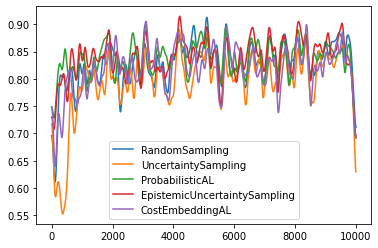

In [6]:
for query_strategy_name, query_strategy in query_strategies.items():
    for clf_name, clf_factory in clf_dict.items():
        clf = clf_factory()
        # initializing the training data
        X_train = np.array(X_init)
        y_train = np.array(y_init)
        # fit initial data
        clf.fit(X_train, y_train)
        # initialize the list that stores the result of the classifier's prediction
        correct_classifications = []
        count = 0
        for t in range(len(X_init)-1, len(X)-1, stream_batch_size):
            # create batch samples
            index_cand = np.arange(t, t+stream_batch_size)
            X_cand = X[index_cand]
            y_cand_true = y[index_cand]
            # add X_cand to X_train
            X_train = np.concatenate([X_train, X_cand])
            # initialize new y_cand with MISSING_LABEL
            y_cand = np.full(shape=y_cand_true.shape, fill_value=MISSING_LABEL)
            # add labels to y_train
            y_train = np.concatenate([y_train, y_cand])
            correct_classifications.extend(clf.predict(X_cand) == y_cand_true)
            X_train_array = np.array(X_train).reshape([len(X_train), X_cand.shape[1]])
            # train the classifier
            clf.fit(X_train, y_train)
            # check whether to sample the instance or not. call_func is used since a classifier is not needed for RandomSampling
            sampled_indices = call_func(query_strategy.query, candidates=index_cand, clf=clf, X=X_train_array, y=y_train, batch_size=query_batch_size, fit_clf=False)
            # count the number of queries
            count += len(sampled_indices)
            # set queried y_cand to true label
            y_train[sampled_indices] = y_cand_true[[s-len(y_train)+stream_batch_size for s in sampled_indices]]
        # calculate and show the average accuracy 
        print(f"Query Strategy: {query_strategy_name}, Avg Accuracy: {np.mean(correct_classifications)}, Acquisation count:", count)
        # smoothing the accuracy for plotting
        plt.plot(gaussian_filter1d(np.array(correct_classifications, dtype=float), 50), label=query_strategy_name)
plt.legend()